In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import numpy as np
from json import loads
import json
from requests.exceptions import HTTPError
import pprint
from datetime import datetime
from dateutil.parser import parse
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from bayes_opt import BayesianOptimization
import toolz

shap.initjs()
from IPython.display import display, clear_output
from bayes_opt import BayesianOptimization
import time


C:\Users\bbennett\Anaconda3\envs\ml\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
print(np.__version__)
print(lgb.__version__)

1.16.4
2.3.0


In [4]:
target_diff = 0.001
stop_loss = 0.001
units = 2000
profit = (target_diff / 0.0001)*(units/8000)
loss = (stop_loss / 0.0001)*(units/8000)

filename_date = '100519'


In [5]:
data = pd.read_csv('../data/' + filename_date + '_mds_out_final_v7_USDCAD.csv')
data.shape

C:\Users\bbennett\Anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (601,602) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(9466, 607)

In [6]:
data[['time', 'target_tp', 'target_sl', 'g', 'l', 'g_time', 'l_time', 'long_target', 'short_target']].head(20)

,time,target_tp,target_sl,g,l,g_time,l_time,long_target,short_target
0,2017-01-19 22:00:00,1.32999,1.32771,2.0,0.0,2017-01-19 23:00:00,NaN,1,0
1,2017-01-20 05:00:00,1.33364,1.33142,9.0,0.0,2017-01-20 06:00:00,NaN,1,0
2,2017-01-20 06:00:00,1.33488,1.33267,10.0,0.0,2017-01-20 07:00:00,NaN,1,0
3,2017-01-20 07:00:00,1.33693,1.33471,11.0,0.0,2017-01-20 08:00:00,NaN,1,0
4,2017-01-20 12:00:00,1.33410,1.33194,16.0,0.0,2017-01-20 13:00:00,NaN,1,0
5,2017-01-20 13:00:00,1.33481,1.33262,17.0,0.0,2017-01-20 14:00:00,NaN,1,0
6,2017-01-20 16:00:00,1.33226,1.33004,20.0,0.0,2017-01-20 17:00:00,NaN,1,0
7,2017-01-22 18:00:00,1.33358,1.33058,22.0,0.0,2017-01-22 19:00:00,NaN,1,0
8,2017-01-22 20:00:00,1.33150,1.32921,24.0,0.0,2017-01-22 21:00:00,NaN,1,0
9,2017-01-23 07:00:00,1.32951,1.32727,35.0,0.0,2017-01-23 08:00:00,NaN,1,0


In [7]:
shift_fields = ['bid_o', 'bid_h','bid_l','bid_c','ask_o','ask_h','ask_l','ask_c']

shift_counter = 1
shift_counter_max = 24

while shift_counter <= shift_counter_max:
    print(shift_counter)
    for s in shift_fields:
        col = s+'_past'+str(shift_counter)
        data[col] = ((data[s] - data[s].shift(shift_counter)) / data[s].shift(shift_counter))*100
    shift_counter+=1
print(data.shape)

data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
(9466, 799)


In [8]:
data['day_of_week'].value_counts()

2    1971
3    1917
1    1903
0    1780
4    1352
6     543
Name: day_of_week, dtype: int64

In [9]:
mds = data.copy()


model_cols = list(mds)
# model_cols.remove('order')
model_cols.remove('time')
model_cols.remove('target_tp')
model_cols.remove('target_sl')
model_cols.remove('long_target')
model_cols.remove('short_target')
# model_cols.remove('g_diff')
# model_cols.remove('g_time_shift')
model_cols.remove('g_time')
model_cols.remove('l_time')
model_cols.remove('bucketwidth_x')
model_cols.remove('bucketwidth_y')
model_cols.remove('instrument')
model_cols.remove('instrument_x')
model_cols.remove('instrument_y')
model_cols.remove('match_time')
model_cols.remove('index')
model_cols.remove('g')
model_cols.remove('l')
model_cols.remove('ask_h')
model_cols.remove('ask_l')
model_cols.remove('ask_c')
model_cols.remove('ask_o')
model_cols.remove('bid_h')
model_cols.remove('bid_l')
model_cols.remove('bid_c')
model_cols.remove('bid_o')
model_cols.remove('volume')
model_cols.remove('diff')
model_cols.remove('same_time')
model_cols.remove('order')



for m in model_cols:
#     print(m)
    mds[m] = pd.to_numeric(mds[m])
    

mds = mds[mds['time'] >= '2018-01-01'].copy()
# mds_train = mds.copy()

mds_train = mds[mds['time'] < '2019-06-01'].copy()
mds = mds[mds['time'] >= '2019-06-01'].copy()
mds['month'] = mds['time'].dt.month


X_train, X_test, y_train, y_test = train_test_split(
     mds_train[model_cols], mds_train['long_target'], test_size=0.33, random_state=42)
     
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

print(mds_train.shape)
print(mds.shape)

(5129, 801)
(964, 802)


In [10]:
def lgb_evaluate(num_leaves,
                 min_child_weight,
                 min_split_gain,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2,
                 min_data,
                 drop_rate,
                 skip_drop,
                 max_drop):

    params['num_leaves'] = int(num_leaves)
    params['min_child_weight'] = int(min_child_weight)
    params['feature_fraction'] = max(feature_fraction,0)
    params['min_split_gain'] = max(min_split_gain, 0)
    params['bagging_fraction'] = max(bagging_fraction,0)
    params['bagging_freq'] = int(bagging_freq)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['min_data'] = int(min_data)
    params['metric'] = 'binary_logloss'
    params['eta'] = 0.1
    params['boost_from_average'] = False
    params['is_unbalance'] = False
    params['num_threads'] = 2
    params['boosting_type']= 'dart'
    params['skip_drop'] = max(skip_drop,0)
    params['drop_rate'] = max(drop_rate,0)
    params['max_drop'] = int(max_drop)

    cv_result = lgb.cv(params, lgb_train, num_boost_round=num_rounds, nfold=3,
             seed=random_state, early_stopping_rounds=500, verbose_eval=50)

    return -cv_result['binary_logloss-mean'][-1]

In [11]:
# num_rounds = 3000
# random_state = 2016
# num_iter = 25
# init_points = 25
# params = {
#     'eta': 0.1,
# #     'silent': 1,
# #     'eval_metric': 'auc',
# #     'verbose_eval': True,
# #     'seed': random_state
# }

# lgbBO = BayesianOptimization(lgb_evaluate, {'num_leaves': (5, 100),
#                                             'min_child_weight': (0, 5),
#                                             'min_split_gain': (0, 5),
#                                             'feature_fraction': (0.1, 1),
#                                             'bagging_fraction': (0.1, 1),
#                                             'bagging_freq': (1, 10),
#                                             'lambda_l2': (0, 1),
#                                             'lambda_l1': (0, 1),
#                                             'min_data': (1,100),
#                                             'drop_rate': (0.1, 0.9),
#                                             'skip_drop': (0.1, 0.9),
#                                             'max_drop': (1,100)
#                                             })

# lgbBO.maximize(init_points=init_points, n_iter=num_iter)

In [12]:
# tracker = {'max':1, 'idx':1000}
# counter = 0
# for f in lgbBO.res:
#     if abs(f['target']) < tracker['max']:
#         tracker['max'] = abs(f['target'])
#         tracker['idx'] = counter
#     counter +=1
    
# best_params = lgbBO.res[tracker['idx']]['params']
# print(tracker)
# print()
# best_params

In [13]:
params = {
        'objective':'binary',
#         'boosting': 'dart',
#         'drop_rate': 0.5,
#         'max_drop': 50,
#         'skip_drop':0.25,
#         'uniform_drop': False,
        'boost_from_average': False,
        'learning_rate': 0.05,
        'min_data': 50,
        'num_leaves': 25,
        'max_depth':6,
#         'lambda_l2': 0.1,
#         'lambda_l1': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 1,
        'min_child_weight': 2,
#         'min_split_gain': 1,
        'verbose': 1,
        'feature_fraction': 0.25,
#         'scale_pos_weight': 100,
#         'is_unbalance': True,
        'metric': ['binary_logloss'],
        'max_bin': 63,
        'num_threads': 2
    } 

# params = {
#     'objective':'binary',
#     'boosting_type': 'dart',
#     'drop_rate': round(best_params['drop_rate'], 2),
#     'max_drop': int(best_params['max_drop']),
#     'skip_drop':  round(best_params['skip_drop'], 2),   
#     'boost_from_average': False,
#     'learning_rate':  0.05,
#     'max_depth': int(best_params['max_depth']),
#     'num_leaves': int(best_params['num_leaves']),
#     'lambda_l2': best_params['lambda_l2'],
#     'lambda_l1': best_params['lambda_l1'],
#     'bagging_fraction':  round(best_params['bagging_fraction'], 2),
#     'bagging_freq': int(best_params['bagging_freq']),
#     'min_data': int(best_params['min_data']),
#     'min_child_weight':  round(best_params['min_child_weight'], 2),
#     'min_split_gain':  round(best_params['min_split_gain'], 2),
#     'verbose': 1,
#     'feature_fraction': round(best_params['feature_fraction'], 2),
# #     'scale_pos_weight': lgbBO.res['max']['max_params']['scale_pos_weight'],
#     'metric': ['binary_error'],
#     'num_threads': 2,
# #     'is_unbalance': True,
# } 


In [14]:
num_round = 100000
lgb_model = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_test], early_stopping_rounds=500, verbose_eval=50, keep_training_booster=True)

Training until validation scores don't improve for 500 rounds
[50]	valid_0's binary_logloss: 0.479204
[100]	valid_0's binary_logloss: 0.44936
[150]	valid_0's binary_logloss: 0.437814
[200]	valid_0's binary_logloss: 0.432319
[250]	valid_0's binary_logloss: 0.42799
[300]	valid_0's binary_logloss: 0.424804
[350]	valid_0's binary_logloss: 0.428604
[400]	valid_0's binary_logloss: 0.429138
[450]	valid_0's binary_logloss: 0.428073
[500]	valid_0's binary_logloss: 0.429278
[550]	valid_0's binary_logloss: 0.431402
[600]	valid_0's binary_logloss: 0.435359
[650]	valid_0's binary_logloss: 0.43745
[700]	valid_0's binary_logloss: 0.437675
[750]	valid_0's binary_logloss: 0.440801
[800]	valid_0's binary_logloss: 0.444729
Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.424804


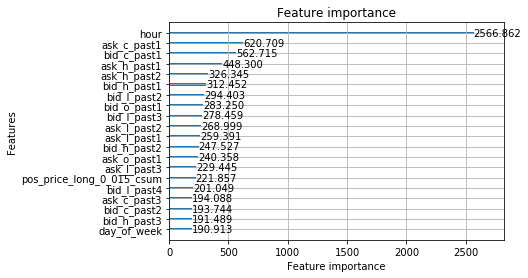

In [15]:
lgb.plot_importance(lgb_model, importance_type='gain', max_num_features=20)

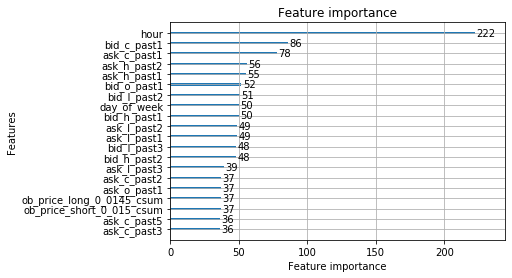

In [16]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=20)

In [17]:
def tf_to_bin(value):
    if value:
        return 1
    else:
        return 0

C:\Users\bbennett\Anaconda3\envs\ml\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


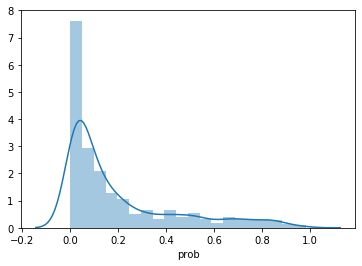

In [18]:
mds['prob'] =  lgb_model.predict(mds[model_cols])
sns.distplot(mds['prob'])

In [19]:
prob_df = pd.DataFrame()
counter = 1
for t in np.arange(0.1, 0.9, 0.0025):
    temp_test = mds.copy()
    temp_test['prob'] =  lgb_model.predict(temp_test[model_cols])
    temp_test['pred'] = temp_test['prob'].apply(lambda x: 1 if x >= t else 0)
    temp_test['tp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 1)
    temp_test['fp'] = (temp_test['pred'] == 1) & (mds['long_target'] == 0)
    temp_test['tn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 0)
    temp_test['fn'] = (temp_test['pred'] == 0) & (mds['long_target'] == 1)
    
    temp = pd.DataFrame()
    temp['cutoff'] = [t]
    temp['total_target'] = mds['long_target'].value_counts()[1]
    temp['tp_cnt'] =  temp_test['tp'].sum()
    temp['fp_cnt'] =  temp_test['fp'].sum()
    temp['tp_pct'] = (temp_test['tp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['fp_pct'] = (temp_test['fp'].sum() / temp_test[['tp', 'fp']].sum().sum())*100
    temp['tp_pct_total'] = (temp_test['tp'].sum() / temp_test[['tp', 'fn']].sum().sum())*100
    if counter == 1:
        prob_df = temp
        counter +=1
    else:
        prob_df = prob_df.append(temp)
        
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pct_diff'] = prob_df['tp_pct'] - prob_df['fp_pct']
prob_df['pl'] = (prob_df['tp_cnt'] * profit) - (prob_df['fp_cnt'] * loss)
positive = prob_df[prob_df['pl'] > 0].copy()
try:
    target_cutoff = positive[positive['pl'] == positive['pl'].max()]['cutoff'].values
    target_cutoff = target_cutoff[len(target_cutoff)-1]
except IndexError:
    print('error')
    target_cutoff= 0.5
# positive = prob_df[prob_df['pct_diff'] > 1].copy()
# target_cutoff_min = positive['cutoff'].min()
# target_cutoff_max = positive['cutoff'].max()
# positive.head()


In [20]:
print(target_cutoff)

0.6325000000000004


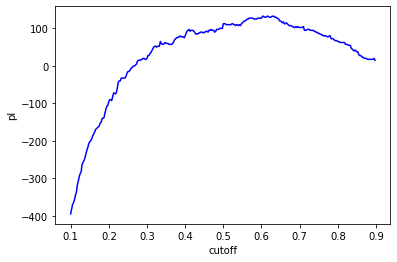

In [21]:
sns.lineplot(x='cutoff', y='pl', data=prob_df,  color='b')

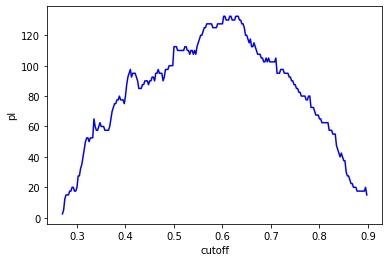

In [22]:
sns.lineplot(x='cutoff', y='pl', data=prob_df[prob_df['pl'] > 0],  color='b')

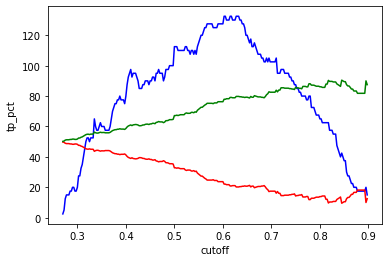

In [23]:
sns.lineplot(x='cutoff', y='pl', data=prob_df[prob_df['pl'] > 0],  color='b')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df[prob_df['pl'] > 0],  color='r')
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df[prob_df['pl'] > 0],  color='g')

0.6325000000000004
(89, 814)
End PL - $132.5


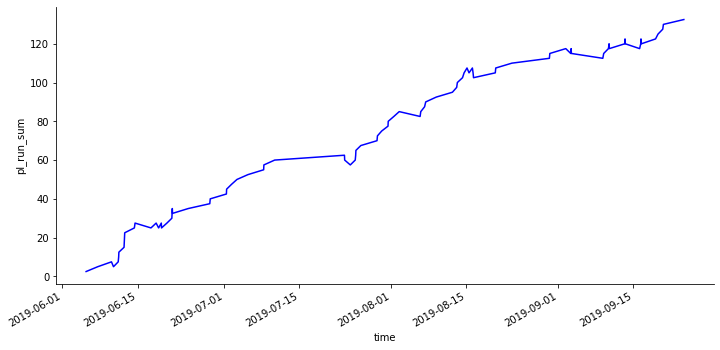

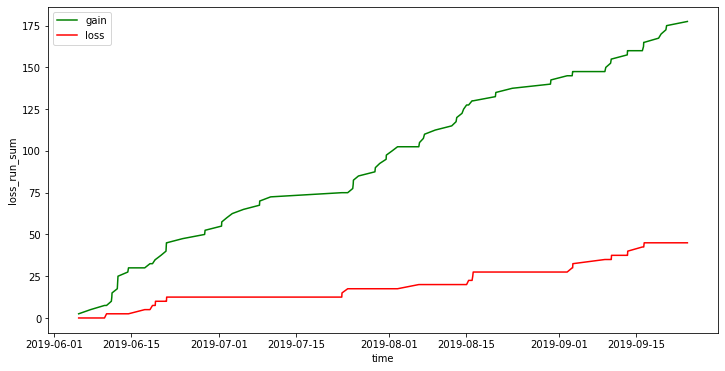

In [24]:
print(target_cutoff)
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

pl_df = pd.concat([tp, fp], axis=0)
pl_df['time'] = pd.to_datetime(pl_df['time'])
pl_df = pl_df.sort_values(by='time')
pl_df['pl_run_sum'] = pl_df['pl'].cumsum()
pl_df['gain_run_sum'] = pl_df['gain'].cumsum()
pl_df['loss_run_sum'] = pl_df['loss'].cumsum()
print(pl_df.shape)
print('End PL - ' + '$'+ str(pl_df['pl_run_sum'].tail(1).values[0]))

g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=pl_df, height=5, aspect=2)
g.fig.autofmt_xdate()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='time', y='gain_run_sum', data=pl_df, color='g')
sns.lineplot(x='time', y='loss_run_sum', data=pl_df, color='r')
plt.legend(['gain', 'loss'])
plt.show()

In [25]:
tp_cnt = 0
fp_cnt = 0

pl_df = pl_df.reset_index(drop=True)
pl_df['index'] = pl_df.index
pl_df['tp_up1'] = pl_df['tp'] .shift(1)
pl_df['fp_up1'] = pl_df['fp'] .shift(1)
pl_df['win_streak'] = 0
pl_df['losing_streak'] = 0
pl_df['tp_runsum'] = pl_df['tp'].cumsum()


for idx, row in pl_df.iterrows():
    if row['tp'] == 1 and row['tp_up1'] != 1.0:
        pl_df.loc[idx, 'win_streak'] = row['win_streak'] +1
        
    elif row['tp'] == 1  and  row['tp_up1'] == 1.0:
        pl_df.loc[idx, 'win_streak'] = pl_df.loc[idx-1, 'win_streak'] +1

    else:
        pl_df.loc[idx, 'win_streak'] = 0
        
    if row['fp'] == 1 and row['fp_up1'] != 1.0:
        pl_df.loc[idx, 'losing_streak'] = row['win_streak'] +1
        
    elif row['fp'] == 1  and  row['fp_up1'] == 1.0:
        pl_df.loc[idx, 'losing_streak'] = pl_df.loc[idx-1, 'losing_streak'] +1

    else:
        pl_df.loc[idx, 'losing_streak'] = 0

win_streak_start = 1
loss_streak_stop = 1
trade_cols = ['time', 'tp', 'fp', 'win_streak', 'losing_streak', 'pl', 'live_pl', 'pl_run_sum', 'gain_run_sum', 'loss_run_sum']
trade_df = pd.DataFrame(columns=trade_cols)
idx_counter = 0
while idx_counter <= pl_df.index.max():
    safe = True
    failed = False
    while not failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['losing_streak'].values[0] <= loss_streak_stop:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                tp_cnt+=1
            else:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
                failed = True
                fp_cnt+=1
        else:
            failed = True
#             fp_cnt+=1

    while failed:
        if idx_counter <= pl_df.index.max():
            temp = pl_df[pl_df['index'] == idx_counter].copy()
            if temp['win_streak'].values[0] <= win_streak_start:
                temp['live_pl'] = 0
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1
#                 fp_cnt+=1
            else:
                temp['live_pl'] = temp['pl'].values[0]
                trade_df = trade_df.append(temp[trade_cols])
                idx_counter+=1 
                failed = False
#                 tp_cnt+1
        else:
            failed = False
#             tp_cnt+=1
            
for c in list(trade_df):
    if c != 'time':
        trade_df[c] = pd.to_numeric(trade_df[c])

trade_df['live_pl_run_sum'] = trade_df['live_pl'].cumsum()
trade_df['time'] = pd.to_datetime(trade_df['time'])

# g = sns.relplot(x="time", y="pl_run_sum", kind="line", color='b', data=trade_df, height=5, aspect=2)
# g.fig.autofmt_xdate()

print('orig total - $'  + str(trade_df['pl_run_sum'].tail(1).values[0]))
print('new total  - $' + str(trade_df['live_pl_run_sum'].tail(1).values[0]))

print(tp_cnt, fp_cnt)

orig total - $132.5
new total  - $132.5
77 4


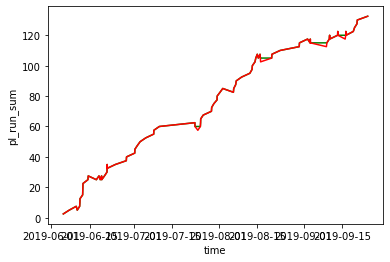

In [26]:
sns.lineplot(x='time', y='live_pl_run_sum', data=trade_df, color='g')
sns.lineplot(x='time', y='pl_run_sum', data=trade_df, color='r')

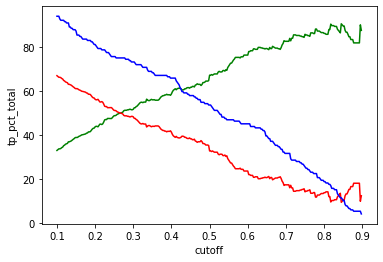

In [27]:
sns.lineplot(x='cutoff', y='tp_pct', data=prob_df, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=prob_df, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=prob_df, color='b')

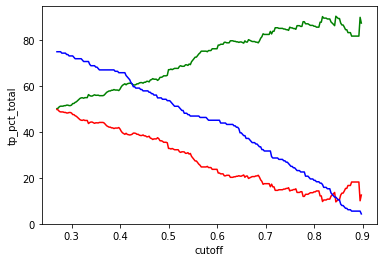

In [28]:
sns.lineplot(x='cutoff', y='tp_pct', data=positive, color='g')
sns.lineplot(x='cutoff', y='fp_pct', data=positive, color='r')
sns.lineplot(x='cutoff', y='tp_pct_total', data=positive, color='b')

In [29]:
mds['month'] = mds['time'].dt.month
mds['prob'] = lgb_model.predict(mds[model_cols])
mds['pred'] = mds.apply(lambda x: 1 if x.prob >= target_cutoff else 0, axis=1)
mds['tp'] = (mds['pred'] == 1) & (mds['long_target'] == 1)
mds['fp'] = (mds['pred'] == 1) & (mds['long_target'] == 0)
mds['tn'] = (mds['pred'] == 0) & (mds['long_target'] == 0)
mds['fn'] = (mds['pred'] == 0) & (mds['long_target'] == 1)

mds['tp'] = mds['tp'].apply(tf_to_bin)
mds['fp'] = mds['fp'].apply(tf_to_bin)
mds['tn'] = mds['tn'].apply(tf_to_bin)
mds['fn'] = mds['fn'].apply(tf_to_bin)

print(mds.shape)

tp = mds[mds['tp'] == 1].copy()
tp['pl'] = profit
tp['gain'] = profit
tp['loss'] = 0

fp = mds[mds['fp'] == 1].copy()
fp['pl'] = -loss
fp['gain'] = 0
fp['loss'] = loss

tn = mds[mds['tn'] == 1].copy()
tn['pl'] = 0
tn['gain'] = 0
tn['loss'] = 0

fn = mds[mds['fn'] == 1].copy()
fn['pl'] = 0
fn['gain'] = 0
fn['loss'] = 0

mds = pd.concat([tp, fp, tn, fn], axis=0)
mds = mds.sort_values(by='time')
print(mds.shape)


(964, 808)
(964, 811)


In [30]:
#Precision
print(mds[['tp']].sum() / mds[['tp', 'fp']].sum().sum())
print()
print(mds[['tp']].sum() / mds[['tp', 'fn']].sum().sum())

tp    0.797753
dtype: float64

tp    0.432927
dtype: float64


In [31]:
mds.groupby(['tp', 'fp', 'tn', 'fn']).size()

tp  fp  tn  fn
0   0   0   1      93
        1   0     782
    1   0   0      18
1   0   0   0      71
dtype: int64

In [32]:
t = mds[mds['long_target'] == 1]
t['prob'].describe()

count    164.000000
mean       0.514270
std        0.270751
min        0.024579
25%        0.271720
50%        0.525308
75%        0.752744
max        0.981736
Name: prob, dtype: float64

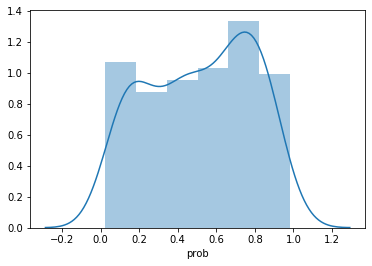

In [33]:
sns.distplot(t['prob'])

In [34]:
t['index'].min()

14454

In [35]:
t['index'].max()

16412

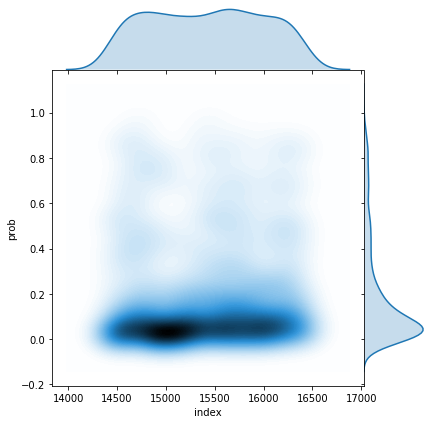

In [36]:
sns.jointplot(x='index', y='prob', data=mds, kind='kde', n_levels=100, space=0, zorder=0)

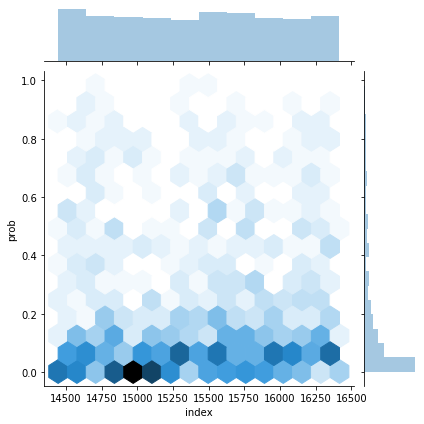

In [37]:
g = sns.jointplot(x='index', y='prob', data=mds, kind='hex')
g.savefig("probs_hex.png")

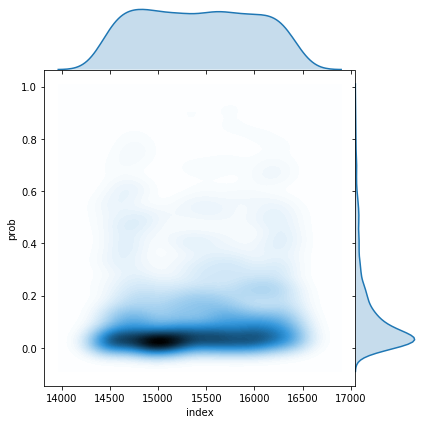

In [38]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] != 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_fp_kde.png")

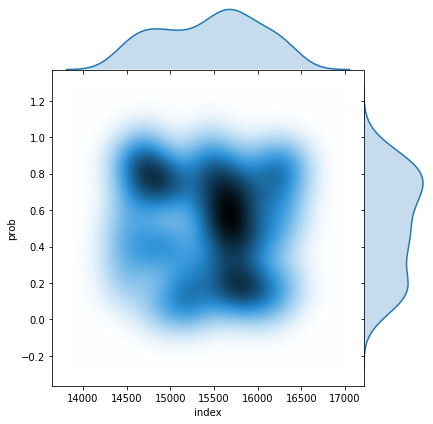

In [39]:
g = sns.jointplot(x='index', y='prob', data=mds[mds['long_target'] == 1], kind='kde', n_levels=100, space=0, zorder=0)
g.savefig("probs_tp_kde.png")

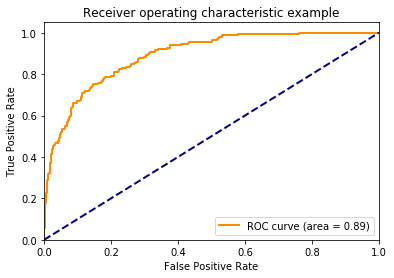

In [40]:
fpr, tpr, _ = roc_curve(mds['long_target'].values, mds['prob'].values )
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [41]:
features = list(X_train)
X = X_train.apply(pd.to_numeric).values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)

C:\Users\bbennett\AppData\Roaming\Python\Python36\site-packages\shap\explainers\tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


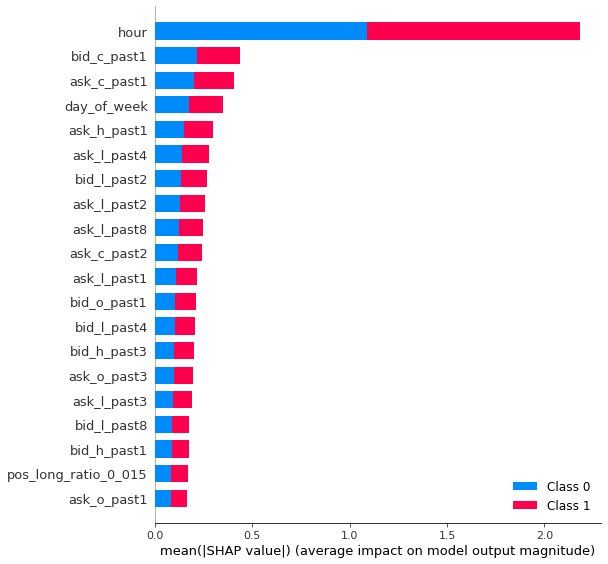

In [42]:
shap.summary_plot(shap_values, X_train, features)

In [43]:
# def get_top_feats(shap_values, num_feats):
#     feature_order = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])
#     feature_order = list(feature_order[-min(num_feats,len(feature_order)):])
#     feature_order = feature_order[::-1]
#     return list(X_train.iloc[:,feature_order])

# top_feats = get_top_feats(shap_values, 20)
# top_feats

In [44]:
# shap.dependence_plot('hour', shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)

In [45]:
# shap.dependence_plot('day_of_week', shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)


In [46]:
mds.groupby(['day_of_week', 'tp', 'fp', 'tn', 'fn']).size() / len(mds)

day_of_week  tp  fp  tn  fn
0            0   0   0   1     0.018672
                     1   0     0.148340
                 1   0   0     0.005187
             1   0   0   0     0.013485
1            0   0   0   1     0.024896
                     1   0     0.168050
                 1   0   0     0.006224
             1   0   0   0     0.016598
2            0   0   0   1     0.015560
                     1   0     0.169087
                 1   0   0     0.002075
             1   0   0   0     0.014523
3            0   0   0   1     0.017635
                     1   0     0.167012
                 1   0   0     0.001037
             1   0   0   0     0.008299
4            0   0   0   1     0.014523
                     1   0     0.108921
                 1   0   0     0.004149
             1   0   0   0     0.020747
6            0   0   0   1     0.005187
                     1   0     0.049793
dtype: float64

In [47]:
# for name in top_feats:
#     print(name)
#     shap.dependence_plot(name, shap_values, X, X_train.columns, interaction_index='auto',
#                              alpha=0.5, dot_size=5, show=False)
#     plt.show()

In [48]:
result_df = mds.copy()
result_df = result_df.sort_values(by='time')
result_df = result_df.reset_index(drop=True)
result_df['id'] = result_df.index
result_df = result_df[['time', 'long_target', 'prob', 'pred', 'tp', 'fp', 'tn', 'fn', 'pl', 'gain', 'loss']]
result_df.to_csv('../data/oanda_USDCAD_long_preds.csv', index=False, header=True)

lgb_model.save_model('../model/oanda_USDCAD_long.txt', num_iteration=-1)
layout_df = pd.DataFrame(list(X_train), columns=['features'])
layout_df.to_csv('../model/oanda_USDCAD_long_layout.csv', index=False, header=True)

info_df = pd.DataFrame()
info_df['long_target_diff'] = [target_diff]
info_df['long_stop_loss'] = stop_loss
info_df['l_target_cutoff'] = target_cutoff
info_df['l_profit'] = profit
info_df['l_loss'] = loss

info_df.to_csv('../model/oanda_USDCAD_long_info.csv', index=False, header=True)

In [49]:
info_df

,long_target_diff,long_stop_loss,l_target_cutoff,l_profit,l_loss
0,0.001,0.001,0.6325,2.5,2.5


In [50]:
mds[['time', 'target_tp', 'target_sl', 'bid_c', 'bid_l', 'ask_c', 'ask_h', 'g', 'l', 'g_time', 'l_time', 'long_target', 'short_target', 'day_of_week']].head(10)

,time,target_tp,target_sl,bid_c,bid_l,ask_c,ask_h,g,l,g_time,l_time,long_target,short_target,day_of_week
6611,2019-06-02 19:00:00,1.35345,1.35127,1.35227,1.35160,1.35245,1.35280,0.0,14448.0,NaN,2019-06-02 21:00:00,0,1,6
9158,2019-06-02 22:00:00,1.35122,1.34905,1.35005,1.34984,1.35022,1.35154,14454.0,0.0,2019-06-03 03:00:00,NaN,0,0,6
2213,2019-06-03 03:00:00,1.35215,1.34998,1.35098,1.34938,1.35115,1.35128,14455.0,0.0,2019-06-03 04:00:00,NaN,1,0,0
6612,2019-06-03 04:00:00,1.35295,1.35078,1.35178,1.35020,1.35195,1.35215,0.0,14457.0,NaN,2019-06-03 06:00:00,0,1,0
6613,2019-06-03 06:00:00,1.35143,1.34925,1.35025,1.35024,1.35043,1.35170,0.0,14459.0,NaN,2019-06-03 08:00:00,0,1,0
6614,2019-06-03 07:00:00,1.35088,1.34871,1.34971,1.34954,1.34988,1.35050,0.0,14460.0,NaN,2019-06-03 09:00:00,0,1,0
2214,2019-06-03 09:00:00,1.34996,1.34781,1.34881,1.34844,1.34896,1.35021,14461.0,0.0,2019-06-03 10:00:00,NaN,1,0,0
6615,2019-06-03 10:00:00,1.35063,1.34830,1.34930,1.34802,1.34963,1.35007,0.0,14462.0,NaN,2019-06-03 11:00:00,0,1,0
6616,2019-06-03 11:00:00,1.34855,1.34639,1.34739,1.34569,1.34755,1.35030,0.0,14463.0,NaN,2019-06-03 12:00:00,0,1,0
6617,2019-06-03 12:00:00,1.34833,1.34618,1.34718,1.34639,1.34733,1.34837,0.0,14465.0,NaN,2019-06-03 14:00:00,0,1,0


In [51]:
100/3

33.333333333333336

In [52]:
3/100

0.03

In [53]:
result_df.head()

,time,long_target,prob,pred,tp,fp,tn,fn,pl,gain,loss
0,2019-06-02 19:00:00,0,0.003470,0,0,0,1,0,0.0,0.0,0.0
1,2019-06-02 22:00:00,0,0.032077,0,0,0,1,0,0.0,0.0,0.0
2,2019-06-03 03:00:00,1,0.150212,0,0,0,0,1,0.0,0.0,0.0
3,2019-06-03 04:00:00,0,0.006631,0,0,0,1,0,0.0,0.0,0.0
4,2019-06-03 06:00:00,0,0.010895,0,0,0,1,0,0.0,0.0,0.0


In [54]:
result_df['prob'].shift(1)

0           NaN
1      0.003470
2      0.032077
3      0.150212
4      0.006631
5      0.010895
6      0.017890
7      0.388256
8      0.019862
9      0.032224
10     0.091110
11     0.025591
12     0.520871
13     0.024605
14     0.305301
15     0.023966
16     0.007256
17     0.247652
18     0.040140
19     0.332665
20     0.031673
21     0.240674
22     0.020864
23     0.014924
24     0.015333
25     0.019331
26     0.016391
27     0.035075
28     0.016419
29     0.017721
30     0.017364
31     0.021355
32     0.422559
33     0.546176
34     0.084712
35     0.034851
36     0.854328
37     0.520018
38     0.485101
39     0.063599
40     0.064217
41     0.142432
42     0.018640
43     0.042311
44     0.032480
45     0.059396
46     0.512131
47     0.047886
48     0.045897
49     0.024066
50     0.017350
51     0.019039
52     0.019003
53     0.011211
54     0.007850
55     0.010555
56     0.192785
57     0.047446
58     0.023126
59     0.005167
60     0.071284
61     0.530899
62     0